In [1]:
%matplotlib inline
import numpy as np
import pyfftw
from nbodykit.lab import *
from nbodykit import setup_logging, style
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize as op
from scipy.interpolate import interp1d
import sys
sys.path.append('../')
sys.path.append('../../')

In [3]:
from cosmology_functions import *

In [4]:
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift=0, transfer='CLASS')

In [5]:
boxsize = 2000.
k0 = 2*np.pi/boxsize

In [6]:
z = 0.5
z_init = 99
Nmesh = 400
Rf = 0
savepath = '/mnt/store2/xwu/AbacusSummit/base_c000_ph006/z%s_tilde_operators_nbody' % str(z)

In [7]:
# G-S orhogalization to get delta^2_perp
def calc_d2p(delta1k, delta2k, L=None, N=None, P_dd=None, P_dd2=None, r=None,
            ind=None, kbins=None, arr=None):
    '''
    Calculate and return delta^2_perp in k space.
    '''
    if P_dd is None:
        kvec, P_dd = calc_powerspectrum(delta1k, L,
                                  ind=ind, kbins=kbins, arr=arr)
    if P_dd2 is None:
        kvec, P_dd2 = calc_powerspectrum(delta1k, L, grid2=delta2k,
                                  ind=ind, kbins=kbins, arr=arr)

    if kbins is not None:
        kvec = (kbins[1:] + kbins[:-1])/2.

    if r is None:
        x, y, z = calc_k_grid(L, N)
        r = (x**2 + y**2 + z**2)**0.5
    ratio = np.interp(np.log10(r), np.log10(kvec), P_dd2.real/P_dd.real)

    delta2kp = delta2k - ratio*delta1k
    return delta2kp

In [8]:
# get G2_perp
def calc_G2p(delta1k, delta2kp, G2, L=None, N=None, P_dd=None, P_d2pd2p=None, r=None,
            ind=None, kbins=None, arr=None):
    if P_dd is None:
        kvec, P_dd = calc_powerspectrum(delta1k, L,
                                  ind=ind, kbins=kbins, arr=arr)
    kvec, P_dG2 = calc_powerspectrum(delta1k, L, grid2=G2,
                                  ind=ind, kbins=kbins, arr=arr)
    if P_d2pd2p is None:
        kvec, P_d2pd2p = calc_powerspectrum(delta2kp, L,
                                  ind=ind, kbins=kbins, arr=arr)
    kvec, P_d2pG2 = calc_powerspectrum(delta2kp, L, grid2=G2,
                                  ind=ind, kbins=kbins, arr=arr)

    if r is None:
        x, y, z = calc_k_grid(L, N)
        r = (x**2 + y**2 + z**2)**0.5
    logr = np.log10(r)

    ratio = np.interp(logr, np.log10(kvec), P_dG2.real/P_dd.real)
    G2p = G2 - ratio*delta1k
    ratio = np.interp(logr, np.log10(kvec), P_d2pG2.real/P_d2pd2p.real)
    G2p -= ratio*delta2kp

    return G2p

In [9]:
Dinit = calc_growthrate(z_init)
Dz = calc_growthrate(z)
Ddiff = Dz - Dinit
Dratio = Dz/Dinit

In [10]:
kx, ky, kz = calc_k_grid(boxsize, Nmesh)
k2 = (kx**2 + ky**2 + kz**2).clip(1e-6)

dk = 2*np.pi/boxsize
_kbins = np.linspace(0.5*dk, (Nmesh//2+0.5)*dk, int(Nmesh/2)+1)
_k = (k2**0.5).ravel()
_ind = np.argsort(_k)
_arr = np.searchsorted(_k[_ind], _kbins)

_k = k2**0.5
del kx, ky, kz, k2

In [11]:
# Zeldovich
f_deltaz = BigFileMesh(savepath+'/deltaz_Nmesh%d_cic.bigfile/' % Nmesh, 'Field')
deltaz = f_deltaz.compute()-1
deltazk = pyfftw.interfaces.numpy_fft.rfftn(deltaz)

In [12]:
# \tilde{\delta}_1
f_tdelta1 = BigFileMesh(savepath+'/Rf%.3g/tdelta1_Nmesh%d_cic.bigfile/' % (Rf,Nmesh), 'Field')
tdelta1 = f_tdelta1.compute()*Dratio
tdelta1k = pyfftw.interfaces.numpy_fft.rfftn(tdelta1)

In [13]:
# \tilde{\delta}_2
f_tdelta2 = BigFileMesh(savepath+'/Rf%.3g/tdelta2_Nmesh%d_cic.bigfile/' % (Rf,Nmesh), 'Field')
tdelta2 = f_tdelta2.compute()*Dratio**2
tdelta2k = pyfftw.interfaces.numpy_fft.rfftn(tdelta2)

In [14]:
# \tilde{G_2}
f_tG2 = BigFileMesh(savepath+'/Rf%.3g/tG2_Nmesh%d_cic.bigfile/' % (Rf,Nmesh), 'Field')
tG2 = f_tG2.compute()*Dratio**2
tG2k = pyfftw.interfaces.numpy_fft.rfftn(tG2)

In [15]:
# load in the snapshot file
cat = CompaSOHaloCatalog('/mnt/store2/bigsims/AbacusSummit/AbacusSummit_base_c000_ph006/halos/z%.3f/' % z,
                         fields=['N', 'x_com', 'r100_com'])

In [16]:
# power spectra of operators and orthogonalize
kvec, P_td1td1 = calc_powerspectrum(tdelta1k, boxsize, ind=_ind, arr=_arr, kbins=_kbins)

tdelta2kp = calc_d2p(tdelta1k, tdelta2k, L=boxsize, N=Nmesh, P_dd=P_td1td1, r=_k,
            ind=_ind, kbins=_kbins, arr=_arr)
kvec, P_td2ptd2p = calc_powerspectrum(tdelta2kp, boxsize, ind=_ind, arr=_arr, kbins=_kbins)

tG2kp = calc_G2p(tdelta1k, tdelta2kp, tG2k, 
    L=boxsize, N=Nmesh, P_dd=P_td1td1, r=_k, ind=_ind, kbins=_kbins, arr=_arr)
kvec, P_tG2ptG2p = calc_powerspectrum(tG2kp, boxsize, ind=_ind, arr=_arr, kbins=_kbins)

In [17]:
# check orthogonalization
P_td1td2p = calc_powerspectrum(tdelta1k, boxsize, ind=_ind, arr=_arr, kbins=_kbins, grid2=tdelta2kp)[1]
P_td1tG2p = calc_powerspectrum(tdelta1k, boxsize, ind=_ind, arr=_arr, kbins=_kbins, grid2=tG2kp)[1]
P_td2tG2p = calc_powerspectrum(tdelta2k, boxsize, ind=_ind, arr=_arr, kbins=_kbins, grid2=tG2kp)[1]

(-200.0, 200.0)

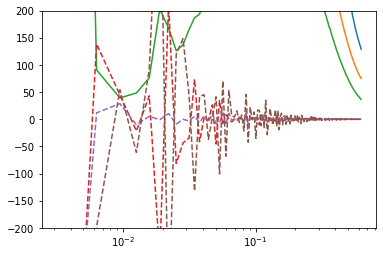

In [18]:
plt.semilogx(kvec, P_td1td1)
plt.plot(kvec, P_td2ptd2p)
plt.plot(kvec, P_tG2ptG2p)
plt.plot(kvec, P_td1td2p, '--')
plt.plot(kvec, P_td1tG2p, '--')
plt.plot(kvec, P_td2tG2p, '--')
plt.ylim(-200, 200)

In [23]:
kvec, P_td2td2 = calc_powerspectrum(tdelta2k, boxsize, ind=_ind, arr=_arr, kbins=_kbins)
kvec, P_tG2tG2 = calc_powerspectrum(tG2k, boxsize, ind=_ind, arr=_arr, kbins=_kbins)

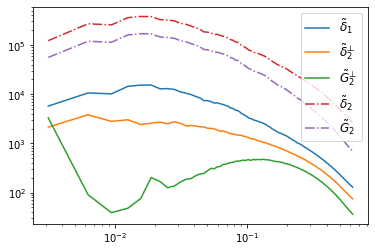

In [25]:
plt.loglog(kvec, P_td1td1, label=r'$\tilde{\delta}_1$')
plt.plot(kvec, P_td2ptd2p, label=r'$\tilde{\delta}_2^\bot$')
plt.plot(kvec, P_tG2ptG2p, label=r'$\tilde{G}_2^\bot$')
plt.plot(kvec, P_td2td2, '-.', label=r'$\tilde{\delta}_2$')
plt.plot(kvec, P_tG2tG2, '-.', label=r'$\tilde{G}_2$')
plt.legend(fontsize=12, loc=1)

### not mass weighted halos

In [51]:
ii = cat.halos['N'] > 150
# convert to grid
delta_h = ArrayCatalog({'Position': cat.halos[ii]['x_com']
                    #, 'Value': cat.halos[ii]['N']
                   }).to_mesh(Nmesh=Nmesh, BoxSize=boxsize, resampler='cic').compute()
delta_h = delta_h/np.mean(delta_h)-1.
deltak_h = pyfftw.interfaces.numpy_fft.rfftn(delta_h)

Pshot_h = boxsize**3/ii.sum()
print(ii.sum(), Pshot_h)

99922748 80.06184937988294


In [52]:
kvec, P_h = calc_powerspectrum(deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)

In [53]:
kvec, P_htd1 = calc_powerspectrum(tdelta1k, boxsize, ind=_ind, arr=_arr, kbins=_kbins, grid2=deltak_h)
kvec, P_htd2p = calc_powerspectrum(tdelta2kp, boxsize, ind=_ind, arr=_arr, kbins=_kbins, grid2=deltak_h)
kvec, P_htG2p = calc_powerspectrum(tG2kp, boxsize, ind=_ind, arr=_arr, kbins=_kbins, grid2=deltak_h)

In [54]:
beta1 = P_htd1.real/P_td1td1.real
beta2 = P_htd2p.real/P_td2ptd2p.real
betaG2 = P_htG2p.real/P_tG2ptG2p.real

Text(0.5, 0, '$k$')

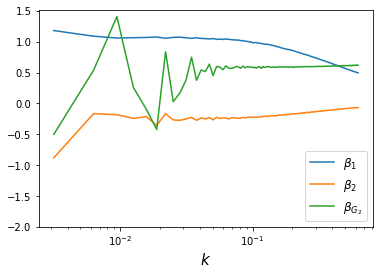

In [55]:
plt.semilogx(kvec, beta1, label=r'$\beta_1$')
plt.semilogx(kvec, beta2, label=r'$\beta_2$')
plt.semilogx(kvec, betaG2, label=r'$\beta_{G_2}$')
plt.ylim(-2)
plt.legend(fontsize=12)
plt.xlabel(r'$k$', fontsize=15)
# plt.ylim(-0.5)

In [56]:
logk = np.log10(_k)
deltak_model = np.interp(logk, np.log10(kvec), beta1)*tdelta1k + \
    np.interp(logk, np.log10(kvec), beta2)*tdelta2kp + \
    np.interp(logk, np.log10(kvec), betaG2)*tG2kp
P_model = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
P_err = calc_powerspectrum(deltak_model-deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]

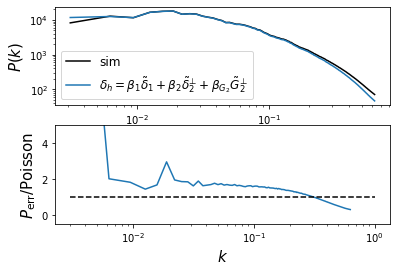

In [32]:
plt.subplot(211)
plt.loglog(kvec, P_h, 'k', label='sim')
plt.plot(kvec, P_model,
        label=r'$\delta_h = \beta_1 \tilde{\delta}_1 + \beta_2 \tilde{\delta}^\bot_2 + \beta_{G_2} \tilde{G}^\bot_2$')
# plt.ylim(1e-1, 1e3)
plt.legend(fontsize=12)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.subplot(212)
plt.semilogx(kvec, P_err/Pshot_h)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P_{\rm err}/$Poisson', fontsize=15)
plt.ylim(-0.5, 5)
plt.plot([0.3e-2,1], [1,1], 'k--')

In [57]:
# what about using beta1 only
deltak_model = np.interp(logk, np.log10(kvec), beta1)*tdelta1k
P_model1 = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
P_err1 = calc_powerspectrum(deltak_model-deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]

In [58]:
# or using beta1 and beta2
deltak_model = np.interp(logk, np.log10(kvec), beta1)*tdelta1k + \
    np.interp(logk, np.log10(kvec), beta2)*tdelta2kp
P_model2 = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
P_err2 = calc_powerspectrum(deltak_model-deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]

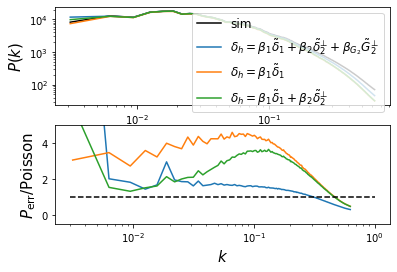

In [60]:
plt.subplot(211)
plt.loglog(kvec, P_h, 'k', label='sim')
plt.plot(kvec, P_model,
        label=r'$\delta_h = \beta_1 \tilde{\delta}_1 + \beta_2 \tilde{\delta}^\bot_2 + \beta_{G_2} \tilde{G}^\bot_2$')
plt.plot(kvec, P_model1,
        label=r'$\delta_h = \beta_1 \tilde{\delta}_1$')
plt.plot(kvec, P_model2,
        label=r'$\delta_h = \beta_1 \tilde{\delta}_1 + \beta_2 \tilde{\delta}^\bot_2$')
# plt.ylim(1e-1, 1e3)
plt.legend(fontsize=12, loc=1)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.subplot(212)
plt.semilogx(kvec, P_err/Pshot_h)
plt.plot(kvec, P_err1/Pshot_h)
plt.plot(kvec, P_err2/Pshot_h)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P_{\rm err}/$Poisson', fontsize=15)
plt.ylim(-0.5, 5)
plt.plot([0.3e-2,1], [1,1], 'k--')

### what about mass weighted

In [37]:
ii = cat.halos['N'] > 150
# convert to grid
delta_h = ArrayCatalog({'Position': cat.halos[ii]['x_com']
                    , 'Value': cat.halos[ii]['N']
                   }).to_mesh(Nmesh=Nmesh, BoxSize=boxsize, resampler='cic').compute()
delta_h = delta_h/np.mean(delta_h)-1.
deltak_h = pyfftw.interfaces.numpy_fft.rfftn(delta_h)

Pshot_h = boxsize**3/ii.sum()
print(ii.sum(), Pshot_h)

99922748 80.06184937988294


In [38]:
kvec, P_h = calc_powerspectrum(deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)

In [39]:
kvec, P_htd1 = calc_powerspectrum(tdelta1k, boxsize, ind=_ind, arr=_arr, kbins=_kbins, grid2=deltak_h)
kvec, P_htd2p = calc_powerspectrum(tdelta2kp, boxsize, ind=_ind, arr=_arr, kbins=_kbins, grid2=deltak_h)
kvec, P_htG2p = calc_powerspectrum(tG2kp, boxsize, ind=_ind, arr=_arr, kbins=_kbins, grid2=deltak_h)

In [40]:
beta1 = P_htd1.real/P_td1td1.real
beta2 = P_htd2p.real/P_td2ptd2p.real
betaG2 = P_htG2p.real/P_tG2ptG2p.real

Text(0.5, 0, '$k$')

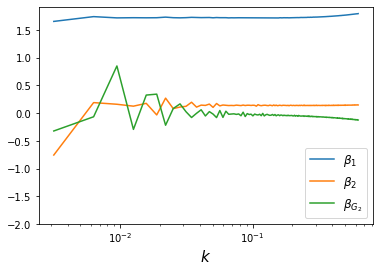

In [41]:
plt.semilogx(kvec, beta1, label=r'$\beta_1$')
plt.semilogx(kvec, beta2, label=r'$\beta_2$')
plt.semilogx(kvec, betaG2, label=r'$\beta_{G_2}$')
plt.ylim(-2)
plt.legend(fontsize=12)
plt.xlabel(r'$k$', fontsize=15)
# plt.ylim(-0.5)

In [42]:
logk = np.log10(_k)
deltak_model = np.interp(logk, np.log10(kvec), beta1)*tdelta1k + \
    np.interp(logk, np.log10(kvec), beta2)*tdelta2kp + \
    np.interp(logk, np.log10(kvec), betaG2)*tG2kp
P_model = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
P_err = calc_powerspectrum(deltak_model-deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]

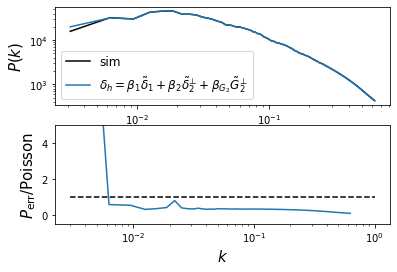

In [43]:
plt.subplot(211)
plt.loglog(kvec, P_h, 'k', label='sim')
plt.plot(kvec, P_model,
        label=r'$\delta_h = \beta_1 \tilde{\delta}_1 + \beta_2 \tilde{\delta}^\bot_2 + \beta_{G_2} \tilde{G}^\bot_2$')
# plt.ylim(1e-1, 1e3)
plt.legend(fontsize=12)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.subplot(212)
plt.semilogx(kvec, P_err/Pshot_h)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P_{\rm err}/$Poisson', fontsize=15)
plt.ylim(-0.5, 5)
plt.plot([0.3e-2,1], [1,1], 'k--')

In [44]:
# what about using beta1 only
deltak_model = np.interp(logk, np.log10(kvec), beta1)*tdelta1k
P_model1 = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
P_err1 = calc_powerspectrum(deltak_model-deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]

In [46]:
# or using beta1 and beta2
deltak_model = np.interp(logk, np.log10(kvec), beta1)*tdelta1k + \
    np.interp(logk, np.log10(kvec), beta2)*tdelta2kp
P_model2 = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
P_err2 = calc_powerspectrum(deltak_model-deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]

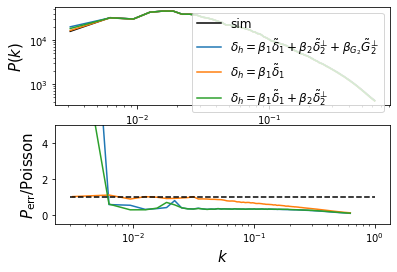

In [48]:
plt.subplot(211)
plt.loglog(kvec, P_h, 'k', label='sim')
plt.plot(kvec, P_model,
        label=r'$\delta_h = \beta_1 \tilde{\delta}_1 + \beta_2 \tilde{\delta}^\bot_2 + \beta_{G_2} \tilde{G}^\bot_2$')
plt.plot(kvec, P_model1,
        label=r'$\delta_h = \beta_1 \tilde{\delta}_1$')
plt.plot(kvec, P_model2,
        label=r'$\delta_h = \beta_1 \tilde{\delta}_1 + \beta_2 \tilde{\delta}^\bot_2$')
# plt.ylim(1e-1, 1e3)
plt.legend(fontsize=12, loc=1)
plt.ylabel(r'$P(k)$', fontsize=15)
plt.subplot(212)
plt.semilogx(kvec, P_err/Pshot_h)
plt.plot(kvec, P_err1/Pshot_h)
plt.plot(kvec, P_err2/Pshot_h)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P_{\rm err}/$Poisson', fontsize=15)
plt.ylim(-0.5, 5)
plt.plot([0.3e-2,1], [1,1], 'k--')